# Holoscope


<a target="_blank" href="https://colab.research.google.com/github/TuragaLab/chromatix/blob/main/docs/examples/holoscope.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# If in colab, install Jax and chromatix. Don't forget to select a GPU!
!pip install --upgrade pip
!pip install "jax[cuda11_cudnn82]==0.4.1" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install git+https://github.com/TuragaLab/chromatix.git

In this example, we'll be simulating the Holoscope, a 3D snapshot microscope as described by [1]: [FourierNets enable the design of highly non-local optical encoders for computational imaging](https://openreview.net/forum?id=Kx1VCs1treH). A 3D snapshot microscope compresses 3D information about a sample into a 2D image, meaning the final 3D volume must be computationally reconstructed. The optimal design for a 3D snapshot microscope is not known in general and is likely highly sample dependent. The Holoscope models a snapshot microscope as a 4f system, allowing a phase mask to produce a (large) depth-varying point spread function (PSF) that can encode 3D information. The design of this phase mask can be optimized pixel-by-pixel using backpropagation through the reconstruction algorithm (e.g. a neural network) and the optical simulation, resulting in a PSF that is optimal for a specific type of sample.

Here, we'll be concerned with just the forward simulation rather than the full optimization of a PSF from data. We'll build up each piece of the simulation, showing how they might be implemented using Chromatix, and then finally we'll show how these pieces are already built into Chromatix and allow for a very compact definition of a microscope as a 4f system.

In [1]:
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
import numpy as np

import matplotlib.pyplot as plt
from skimage.data import cells3d

from chromatix import Field
from chromatix.systems import OpticalSystem, Microscope, Optical4FSystemPSF
from chromatix.elements import ObjectivePointSource, PhaseMask, FFLens
from chromatix.functional.phase_masks import defocused_ramps
from chromatix.ops.noise import shot_noise
from chromatix.ops.ops import downsample, fourier_convolution
from chromatix.ops.windows import sigmoid_taper
from chromatix.utils import center_crop, trainable


from typing import Callable, Optional, Tuple, Union
from functools import partial
from chex import Array

key = random.PRNGKey(4)

%config InlineBackend.figure_format='retina'

The very first thing we need to do is to simulate the point spread function (PSF) of a 4f system with a phase mask at multiple planes. When we do this, we'll want to simulate a larger field of view than our camera can capture to make sure we're not cutting off our PSF, and then crop to the sensor field of view. When we do this cropping, we can also smoothly taper the edge of the PSF to 0 to make sure we don't get edge artifacts from convolving the PSF with the sample. We'll need to create some optical parameters to define these steps:

In [2]:
camera_shape: Tuple[int, int] = (1280, 1280)
camera_pixel_pitch: float = 0.325 # microns
z: Array = jnp.linspace(-100, 100, num=40)
f: float = 100.0 # microns
n: float = 1.33
NA: float = 0.8
spectrum: float = 0.532 # 532 nm in microns
spectral_density: float = 1.0
downsample_factor: int = 5
pad: int = 640
taper_width: Optional[float] = 5

As we simulate light at different planes of the 4f system, the spacing we have chosen will change. We can calculate what the spacing must be in the back focal plane of the objective (the first lens) in order to produce the desired output at the image plane:

In [3]:
shape = tuple(np.array(camera_shape).astype(int) + pad)
spacing = f * spectrum / (n * shape[0] * camera_pixel_pitch)
print(f"Shape of simulation: {shape}")
print(f"Input spacing of simulation: {spacing:.3f}")
print(f"Target spacing of simulation: {camera_pixel_pitch:.3f}")

Shape of simulation: (1920, 1920)
Input spacing of simulation: 0.064
Target spacing of simulation: 0.325


## Modeling the PSF of a 4f system with a phase mask

Our 4f system consists of an objective lens (2 focal lengths, i.e. 2f), a phase mask in the Fourier plane of this lens, and then a second lens (another 2 focal lengths/2f) to bring us to the image plane. We'll first calculate what we want the phase mask of this system to look like. This phase mask should produce a PSF that creates multiple images of our sample at different depths and projected along different angles. This will be how we encode 3D information in the scene. To do this, we'll be using the initial phase mask from [[1]](https://openreview.net/forum?id=Kx1VCs1treH), which was called "defocused ramps". This phase function is already part of Chromatix, so we can see what it looks like below:

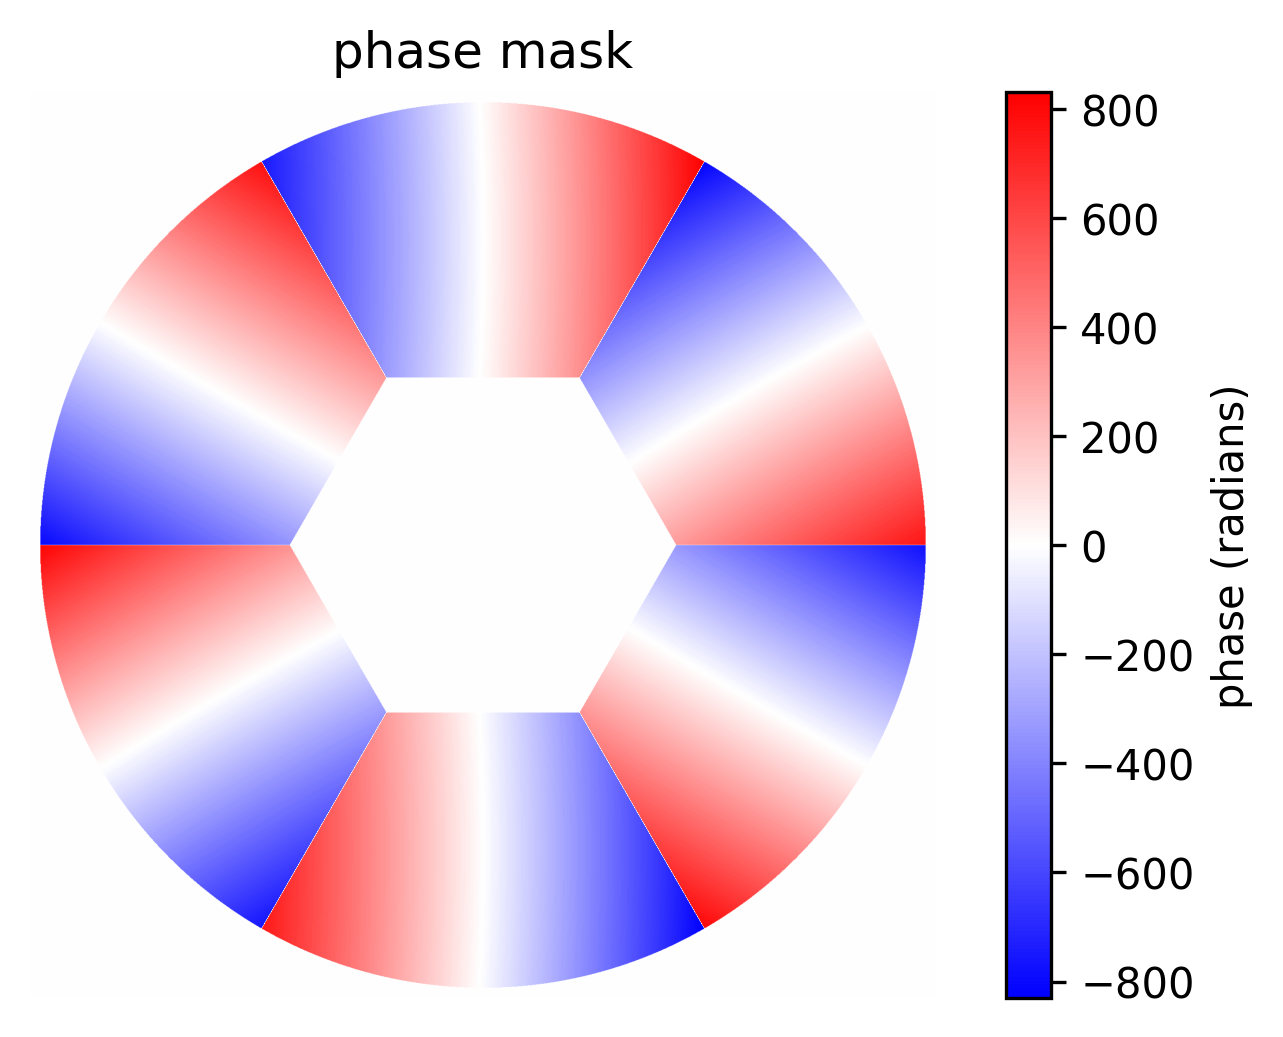

In [4]:
init_phase = defocused_ramps(shape, spacing, spectrum, n, f, NA, delta=[1582.0] * 6)
plt.figure(dpi=150)
plt.imshow(init_phase.squeeze(), cmap='bwr')
plt.colorbar(label="phase (radians)")
plt.title("phase mask")
plt.axis("off")
plt.show()

What we want to do is to sandwich this phase mask between two lenses, and then simulate what happens to a point source that we place before the objective lens. We want to be able to move this point source by some `z` value to observe the effect of defocusing the point source away from the focal plane of the objective. In Chromatix, we can describe a point source passing through a thin lens analytically using `ObjectivePointSource`, which produces the effect of a . When we call this element, we can pass the `z` value defining the defocus of the point source from the focal plane of the objective. We can then use a `PhaseMask` to apply the phase that we just created at the Fourier plane, and then finally an `FFLens` (a 2f lens), which computes the `Field` at the image plane. We'll make sure that the phase is a trainable parameter using `trainable`. We can wrap all of this up into an `OpticalSystem` as shown:

In [5]:
# This is where Chromatix is doing its job --- simulating the 
# 4f system with a point source at different depths. This lets
# us write the optical simulation part of this model in just
# a few lines of code.
system_psf = OpticalSystem([
    ObjectivePointSource(shape, spacing, spectrum, spectral_density, f, n, NA),
    PhaseMask(trainable(init_phase)),
    FFLens(f, n)
])
params = system_psf.init({"params": key}, z=z)
psf = system_psf.apply(params, z)

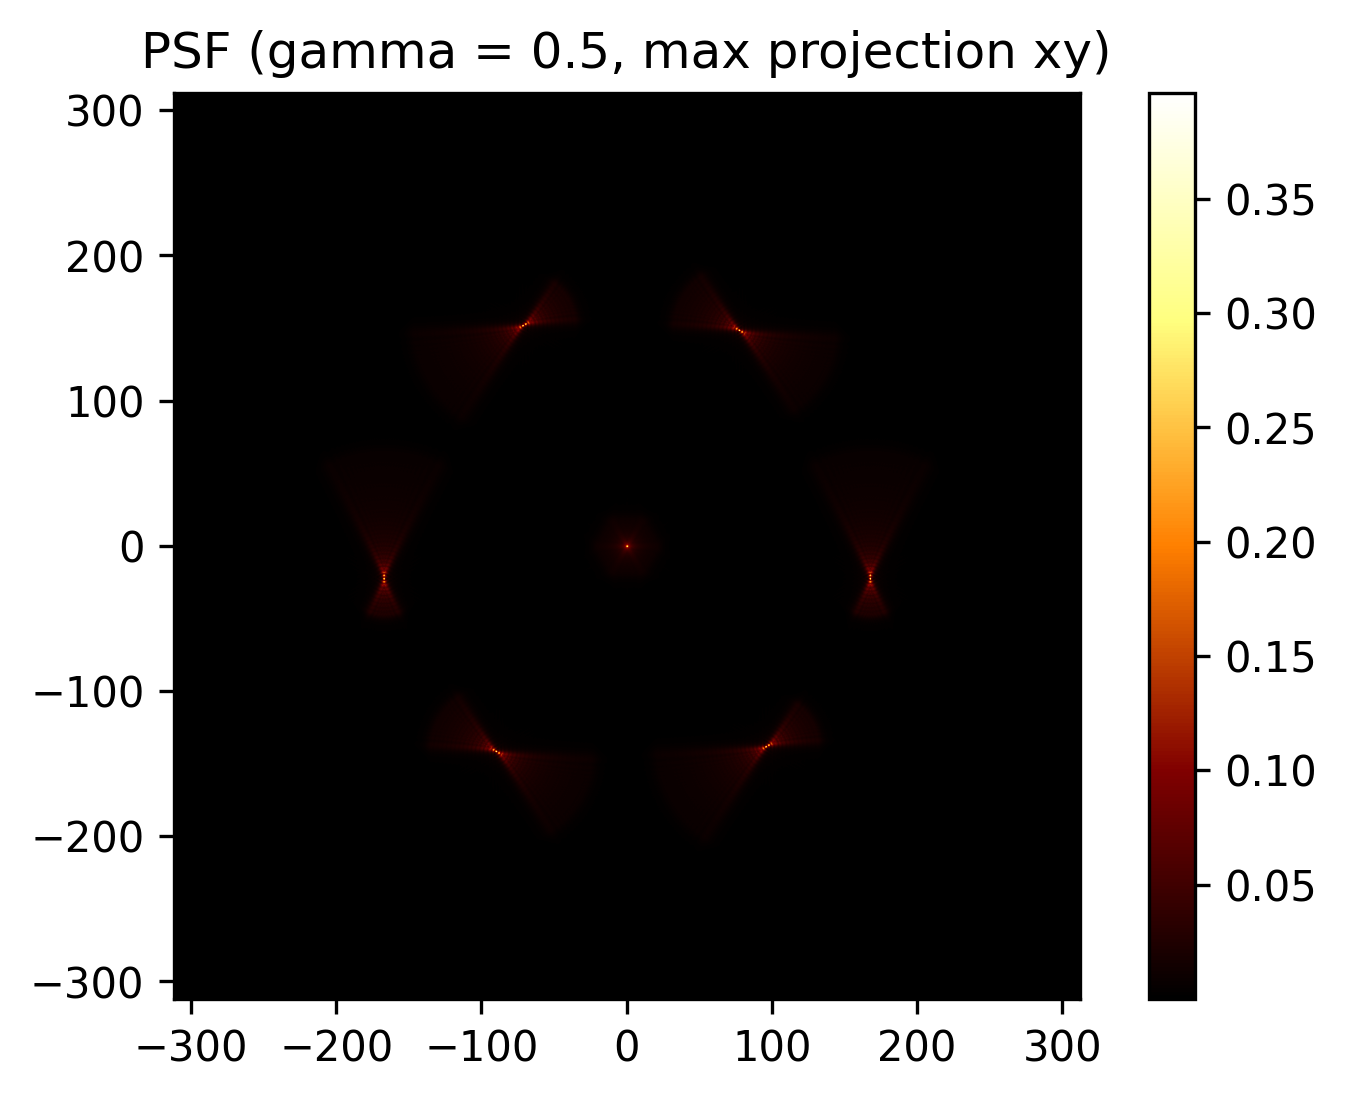

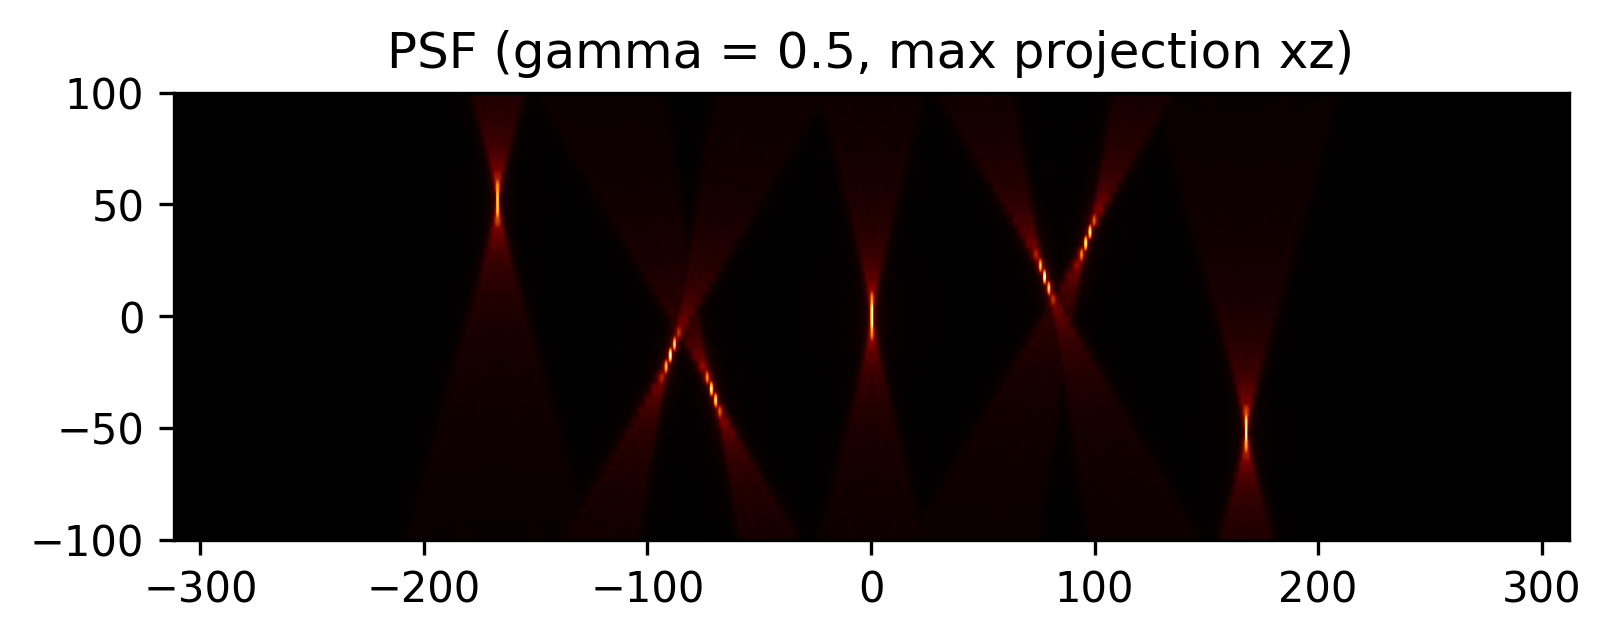

In [6]:
plt.figure(dpi=150)
plt.imshow((psf.intensity ** 0.5).max(0).squeeze(), cmap="afmhot", extent=(-312, 312, -312, 312))
plt.colorbar()
plt.title("PSF (gamma = 0.5, max projection xy)")
plt.show()

plt.figure(dpi=150)
plt.imshow((psf.intensity ** 0.5).max(1).squeeze(), cmap="afmhot", extent=(-312, 312, -100, 100))
plt.title("PSF (gamma = 0.5, max projection xz)")
plt.show()

We're simulating the PSF at a very high resolution, but in practice we might want to save memory during the imaging by downsampling the PSF. We could do interpolation for downsampling the PSF to arbitrary shapes, but for now we can follow [[1]](https://openreview.net/forum?id=Kx1VCs1treH) and use a sum pool to downsample the PSF intensity. We'll also taper the PSF to 0 at the edges to avoid artifacts from the cropping.

In [7]:
def crop_and_downsample(psf: Array) -> Array:
    psf = center_crop(psf, (None, pad // 2, pad // 2, None))
    psf = downsample(psf, (downsample_factor, downsample_factor), reduction="sum")
    return psf * sigmoid_taper((256, 256), taper_width)

## Simulating a snapshot image

We'll be using a synthetic 3D dataset from skimage, because it's easy to load. **This is clearly not the real scale** for these cells given the field of view that we have set of 416 microns, but we can pretend that it's okay for now so that we have a 3D sample to look at.

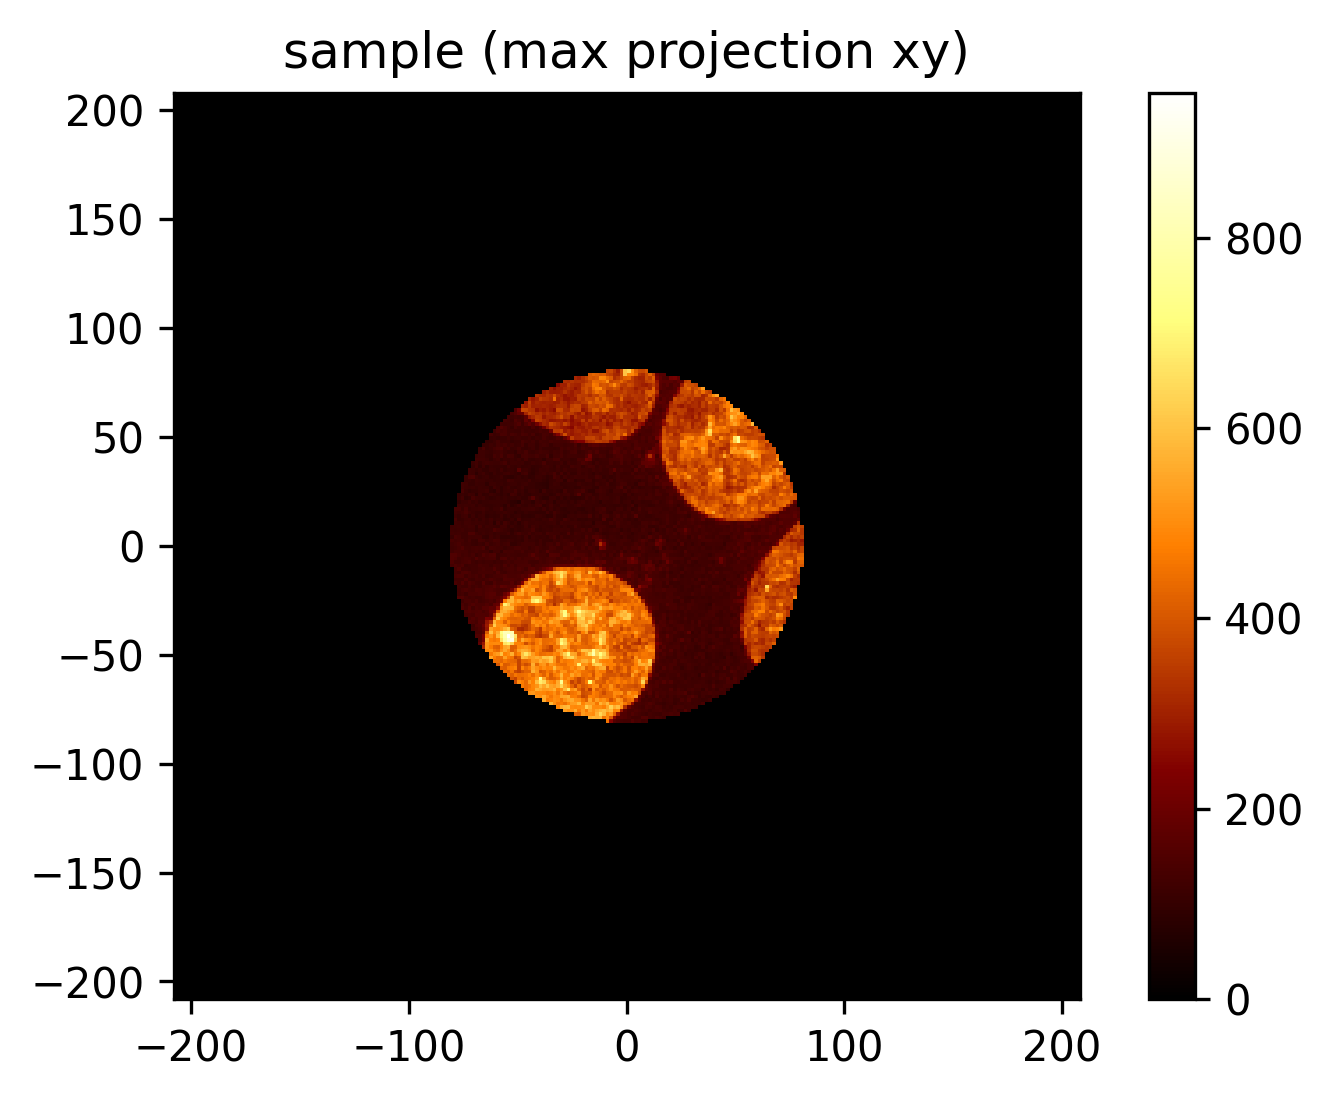

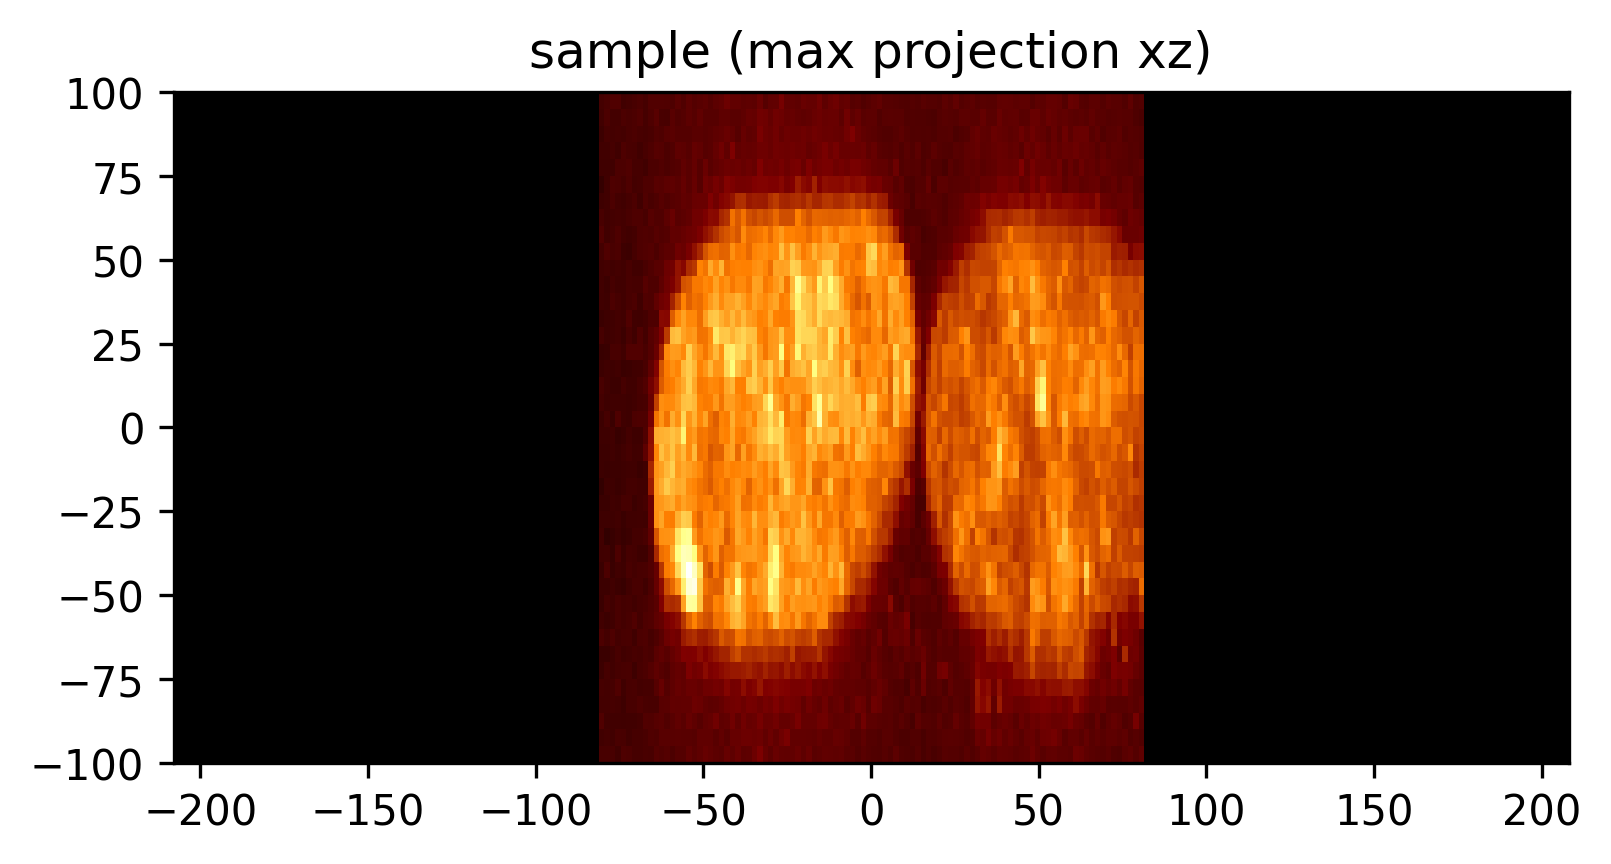

In [8]:
# Prepping data, we only take the nuclei
sample = cells3d()[15:55, 1, ..., None]
# Apply an aperture to the data so the result looks nicer
grid = np.meshgrid(np.linspace(-128, 128, num=256), np.linspace(-128, 128, num=256))
grid = np.sqrt(grid[0] ** 2 + grid[1] ** 2)
sample *= (grid < 50)[None, ..., None]
# Rescale volume data to approximately reasonable photon count per voxel
sample = sample / 50
plt.figure(dpi=150)
plt.imshow((sample).max(0).squeeze(), cmap="afmhot", extent=(-208, 208, -208, 208))
plt.colorbar()
plt.title("sample (max projection xy)")
plt.show()

plt.figure(dpi=150)
plt.imshow((sample).max(1).squeeze(), cmap="afmhot", extent=(-208, 208, -100, 100))
plt.title("sample (max projection xz)")
plt.show()

In [9]:
@jax.jit
def simulate_image(params, key, z: float, sample: Array) -> Array:
    psf = system_psf.apply(params, z).intensity
    psf = crop_and_downsample(psf)
    image = fourier_convolution(psf, sample, axes=(1, 2))
    image = jnp.sum(image, axis=0)
    image = shot_noise(key, image)
    return image

Of course, if we wanted to save some computation, we could cache the PSF after we computed it. However, this would not be appropriate if we intended to optimize the phase mask because then we would need to compute the PSF on every iteration of optimzation anyway. Thus, we are not demonstrating how to cache the PSF here.

With all of the pieces in place, we can finally simulate what an image from the Holoscope looks like!

In [10]:
image = simulate_image(params, key, z, sample)

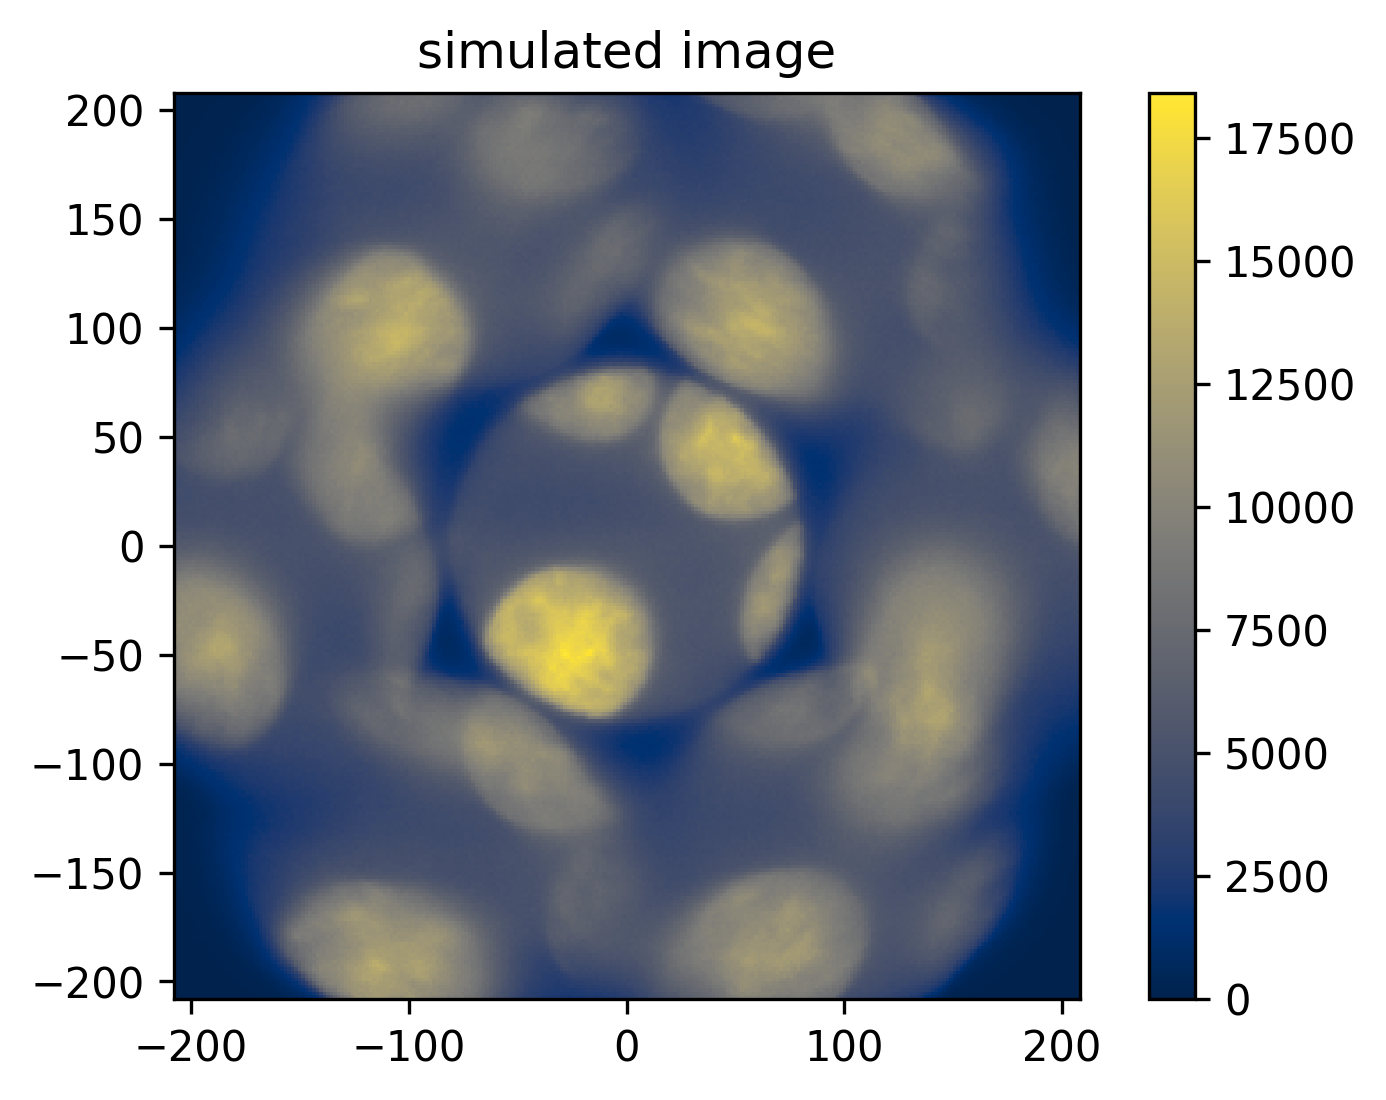

In [11]:
plt.figure(dpi=150)
plt.imshow(image.squeeze(), cmap="cividis", extent=(-208, 208, -208, 208))
plt.colorbar()
plt.title("simulated image")
plt.show()

We can see that this image consists of multiple views of the sample along different angles, and also from different depth planes. We could combine this model with a [FourierNet](https://github.com/TuragaLab/fouriernet/tree/jax) to learn to optimize a PSF that is more optimal for this class of sample. Here, however, we'll show how you can combine the imaging simulation we've made into a convenient Flax `Module`, and then how that is already a part of Chromatix with a few extra features.

## Creating a Microscope in Chromatix

Let's begin by creating a `Module` for our microscope that holds the optical parameters we need, automatically figures out our spacing, performs the cropping and downsampling we need, simulates the PSF, and finally simulates an image.

In [12]:
class Holoscope(nn.Module):
    sensor_shape: Tuple[int, int]
    sensor_spacing: float
    psf_shape: Tuple[int, int]
    psf_spacing: float
    pad: int
    taper_width: float
    phase: Union[Callable[[random.PRNGKey], Array], Array]
    f: float
    n: float
    NA: float
    spectrum: Array
    spectral_density: Array

    @nn.compact
    def __call__(self, sample: Array, z: Array) -> Array:
        psf = self.psf(z).intensity
        psf = self.crop_and_downsample(psf)
        image = fourier_convolution(psf, sample, axes=(1, 2))
        image = jnp.sum(image, axis=0, keepdims=True)
        noise_key = self.make_rng("noise")
        image = shot_noise(noise_key, image)
        return image

    def psf(self, z: Array) -> Field:
        shape = tuple(np.array(self.psf_shape).astype(int) + pad)
        spacing = self.f * self.spectrum / (self.n * shape[0] * self.psf_spacing)
        system_psf = OpticalSystem([
            ObjectivePointSource(shape, spacing, self.spectrum, self.spectral_density, self.f, self.n, self.NA),
            PhaseMask(self.phase, self.f, self.n, self.NA),
            FFLens(self.f, self.n)
        ])
        return system_psf(z)
    
    def crop_and_downsample(self, psf: Array) -> Array:
        downsample_factor = int(self.sensor_spacing / self.psf_spacing)
        assert downsample_factor >= 1, "PSF must have finer spacing than sensor"
        psf = center_crop(psf, (None, pad // 2, pad // 2, None))
        psf = downsample(psf, (downsample_factor, downsample_factor), reduction="sum")
        return psf * sigmoid_taper((256, 256), self.taper_width)

We can use this new `Module` in a similar way to what we did previously, except this is now a composable unit inside or along with any other `Module` s (e.g. in an autoencoder for optimizing PSFs as in [[1]](https://openreview.net/forum?id=Kx1VCs1treH)).

In [13]:
holoscope = Holoscope(
    sensor_shape=(512, 512),
    sensor_spacing=1.625,
    psf_shape=(1280, 1280),
    psf_spacing=0.325,
    pad=640,
    taper_width=5.0,
    phase=trainable(init_phase),
    f=100.0,
    n=1.33,
    NA=0.8,
    spectrum=0.532,
    spectral_density=1.0
)
params = holoscope.init({"params": key, "noise": key}, sample, z)
image = holoscope.apply(params, sample, z, rngs={"noise": key})

In fact, since spatially invariant microscope models are so common, Chromatix already contains a wrapper for this kind of imaging. Further, since the PSF of a 4f system is also a common need, Chromatix also contains a wrapper for this PSF, which can optionally have a trainable phase mask. This `Microscope` `Module` in Chromatix accepts arbitrary models for its PSF, and you can take a look at how to make a `Module` that plugs into this `Microscope` by looking at the [documentation](https://chromatix.readthedocs.io/en/latest/). The `Microscope` also takes a few extra options that we didn't cover here, such as downsampling to arbitrary sensor resolutions, not just those which are an integer multiple of the PSF sampling. Here's what the Holoscope could look like in Chromatix:

In [14]:
holoscope = Microscope(
    system_psf=Optical4FSystemPSF(
        shape=(1280, 1280),
        spacing=0.325,
        phase=trainable(partial(defocused_ramps, delta=[1582.0] * 6))
    ),
    sensor_shape=(256, 256),
    sensor_spacing=1.625,
    f=100.0,
    n=1.33,
    NA=0.8,
    spectrum=0.532,
    spectral_density=1.0,
    padding_ratio=0.5, # padding takes a proportion instead of a count
    taper_width=5.0,
    shot_noise_mode="poisson",
    psf_resampling_method="cubic", # change to "linear" or "cubic" for non-integer downsampling
    reduce_axis=0 # if None, Microscope returns a batch of 2D images
)
params = holoscope.init({"params": key, "noise": key}, sample, z)
image = holoscope.apply(params, sample, z, rngs={"noise": key})